In [28]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [29]:
tf.__version__
#!ls

'2.2.0'

In [30]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16828422773667970345,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6380925276426344268
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1795332885450079291
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10707671488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7099531913060695275
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"]

In [31]:
tf.random.set_seed(999)
np.random.seed(999)

#### Datasets

In [25]:
# default dataset
#!wget 'cdn.daitan.com/dataset.zip'
# dataset_file_name = './dataset.zip'
# with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
#     zip_ref.extractall('./dataset')

--2021-01-31 14:43:23--  http://cdn.daitan.com/dataset.zip
Resolving cdn.daitan.com (cdn.daitan.com)... 52.85.115.120, 52.85.115.9, 52.85.115.54, ...
Connecting to cdn.daitan.com (cdn.daitan.com)|52.85.115.120|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.daitan.com/dataset.zip [following]
--2021-01-31 14:43:23--  https://cdn.daitan.com/dataset.zip
Connecting to cdn.daitan.com (cdn.daitan.com)|52.85.115.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1779066768 (1.7G) [application/zip]
Saving to: ‘dataset.zip’

100%[====================================>] 1,779,066,768 27.3MB/s   in 61s    

2021-01-31 14:44:25 (27.8 MB/s) - ‘dataset.zip’ saved [1779066768/1779066768]



In [237]:
#path_to_dataset = "./dataset/tfrecords" #default
path_to_dataset = "./records"

In [238]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))
test_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'test_*'))

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)
print("Test file names: ", test_tfrecords_filenames)

Training file names:  ['./records/train_0.tfrecords', './records/train_1.tfrecords']
Validation file names:  ['./records/val_0.tfrecords']
Test file names:  ['./records/test_0.tfrecords']


In [161]:
# ts_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'ts_*'))
# ts_tfrecords_filenames = ['./records/ts_0.tfrecords']

In [224]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [39]:
# mozilla_basepath = "./dataset/en"
# UrbanSound8K_basepath = './dataset/UrbanSound8K'
mozilla_basepath = './cv-corpus-6.1-2020-12-11/ru'

### I struggled with an error when opening .mp3 files
### Spent almost a working day trying to fix it
### In the end I gave up and converted the whole dataset to .wav with ffmpeg CLI

## Prepare Input features

In [225]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

In [226]:
def tf_record_parser_(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude, noise_stft_phase

## Create tf.Data.Dataset

In [239]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser_)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [240]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser_)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

In [241]:
val_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
val_dataset = val_dataset.map(tf_record_parser_)
val_dataset = val_dataset.repeat(1)
val_dataset = val_dataset.batch(512)

In [83]:
#####

In [89]:
# tr_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
# tr_dataset = tr_dataset.map(tf_record_parser_)
# tr_dataset = tr_dataset.shuffle(8192)
# tr_dataset = tr_dataset.repeat()
# tr_dataset = tr_dataset.batch(512)
# tr_dataset = tr_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [211]:
# ts_dataset = tf.data.TFRecordDataset([ts_tfrecords_filenames])
# ts_dataset = ts_dataset.map(tf_record_parser_)
# ts_dataset = ts_dataset.repeat(1)
# ts_dataset = ts_dataset.batch(512)

## Model Training

In [230]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [231]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
  x = Activation('relu')(x)
  if use_bn:
    x = BatchNormalization()(x)
  return x

In [232]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  shortcut = x
  in_channels = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

  return shortcut + x

In [233]:
def build_model(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [253]:
model = build_model(l2_strength=0.0001)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 129, 8, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 137, 8, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 129, 1, 18)   1296        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 129, 1, 18)   0           conv2d_48[0][0]                  
____________________________________________________________________________________________

In [48]:
#model = tf.keras.models.load_model('./denoiser_cnn_log_mel_generator.h5')

In [41]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [42]:
#%tensorboard --logdir logs

In [243]:
model.evaluate(val_dataset)

784/784 [==============================] - 34s 43ms/step - loss: 0.0227 - rmse: 0.9215


[0.02272026799619198, 0.9215190410614014]

In [254]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

784/784 [==============================] - 35s 45ms/step - loss: 0.0452 - rmse: 0.9442
Baseline accuracy 0.045221004635095596


In [255]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [256]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

In [257]:
model.fit(train_dataset,
         steps_per_epoch=200, # you might need to change this
         validation_data=test_dataset,
         epochs=5,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/5
200/200 [==============================] - 42s 208ms/step - loss: 0.1024 - rmse: 1.1621 - val_loss: 0.0407 - val_rmse: 0.9303
Epoch 2/5
200/200 [==============================] - 42s 208ms/step - loss: 0.0508 - rmse: 0.9883 - val_loss: 0.0385 - val_rmse: 1.0427
Epoch 3/5
200/200 [==============================] - 43s 217ms/step - loss: 0.0375 - rmse: 1.1828 - val_loss: 0.0349 - val_rmse: 1.2483
Epoch 4/5
200/200 [==============================] - 41s 205ms/step - loss: 0.0513 - rmse: 1.1785 - val_loss: 0.0325 - val_rmse: 1.2553
Epoch 5/5
200/200 [==============================] - 41s 207ms/step - loss: 0.0211 - rmse: 1.7462 - val_loss: 9.0071e-04 - val_rmse: 2.7025


In [304]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
  print("New model saved.")
  model.save('./denoiser_cnn_log_mel_generator.h5')

784/784 [==============================] - 36s 46ms/step - loss: 9.0071e-04 - rmse: 2.7025
New model saved.


In [48]:
#model = tf.keras.models.load_model('./denoiser_cnn_log_mel_generator.h5')

## Testing

In [258]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr

from data_processing.feature_extractor import FeatureExtractor

# def play(audio, sample_rate):
#     ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [265]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    print(noisySTFT.shape)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [273]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

#### ------------ obtaining audio from dataset------------------

In [277]:
def audio_from_set(dataset, n =0, clean = False):
    iter = 0
    for rec in dataset:
        if iter == n:
            #return revert_features_to_audio(rec[0], np.transpose(rec[2]))
            return rec[clean], np.transpose(rec[2])
        iter += 1
    return None

In [278]:
#### VALIDATION ######

In [279]:
mags1, nois1 = audio_from_set(val_dataset, 50)
feats1 = model.predict(mags1)
feats1.shape

(512, 129, 1, 1)

In [280]:
print("Min:", np.min(mags1),"Max:",np.max(mags1))
print("Min:", np.min(nois1),"Max:",np.max(nois1))

Min: -9.347207 Max: 11.273533
Min: -3.1415927 Max: 3.1415927


In [281]:
#### DENOISED
denois1 = revert_features_to_audio(feats1, nois1)
print("Min:", np.min(denois1),"Max:",np.max(denois1))
ipd.Audio(data=denois1, rate=fs)

Min: -0.73723453 Max: 0.8726872


In [282]:
mags1.numpy().shape, denois1.shape

((512, 129, 8, 1), (32704,))

In [283]:
### NOISY
first_train = revert_features_to_audio(mags1.numpy()[:,:, 7,:], nois1)
print("Min:", np.min(first_train),"Max:",np.max(first_train))
ipd.Audio(data=first_train, rate=fs)

Min: -0.27997148 Max: 0.24453095


In [284]:
### CLEAN
ipd.Audio(data=revert_features_to_audio(*audio_from_set(val_dataset, 50, clean=True)), rate=fs)

In [ ]:
##### TRAIN #####

In [290]:
nth = 10

In [291]:
mags2, nois2 = audio_from_set(train_dataset, nth)
feats2 = model.predict(mags2)
feats2.shape

(512, 129, 1, 1)

In [292]:
### DENOISED
denois2 = revert_features_to_audio(feats2, nois2)
print("Min:", np.min(denois2),"Max:",np.max(denois2))
print(denois2.shape)
ipd.Audio(data=denois2, rate=fs)

Min: -0.54595023 Max: 0.72101283
(32704,)


In [293]:
### NOISY
first_t = revert_features_to_audio(mags2.numpy()[:,:, 7,:], nois2)
print("Min:", np.min(first_t),"Max:",np.max(first_t))
print(first_t.shape)
ipd.Audio(data=first_t, rate=fs)

Min: -0.19554171 Max: 0.21211545
(32704,)


In [294]:
### CLEAN
ipd.Audio(data=revert_features_to_audio(*audio_from_set(train_dataset, nth, clean=True)), rate=fs)

In [ ]:
##### TEST SET #######

In [295]:
nth = 35

In [296]:
mags3, nois3 = audio_from_set(test_dataset, nth)
feats3 = model.predict(mags3)
feats3.shape

(512, 129, 1, 1)

In [297]:
### DENOISED
first_ts = revert_features_to_audio(feats3, nois3)
print("Min:", np.min(first_ts),"Max:",np.max(first_ts))
ipd.Audio(data=first_ts, rate=fs)

Min: -0.6352411 Max: 0.7024857


In [298]:
### NOISY
first_tt = revert_features_to_audio(mags3.numpy()[:,:, 7,:], nois3)
print("Min:", np.min(first_tt),"Max:",np.max(first_tt))
ipd.Audio(data=first_tt, rate=fs)

Min: -0.26821965 Max: 0.23322468


In [301]:
### CLEAN
clean_audio = revert_features_to_audio(*audio_from_set(test_dataset, nth, clean=True))
ipd.Audio(data=clean_audio, rate=fs)

Text(0.5, 1.0, 'Denoised Audio')

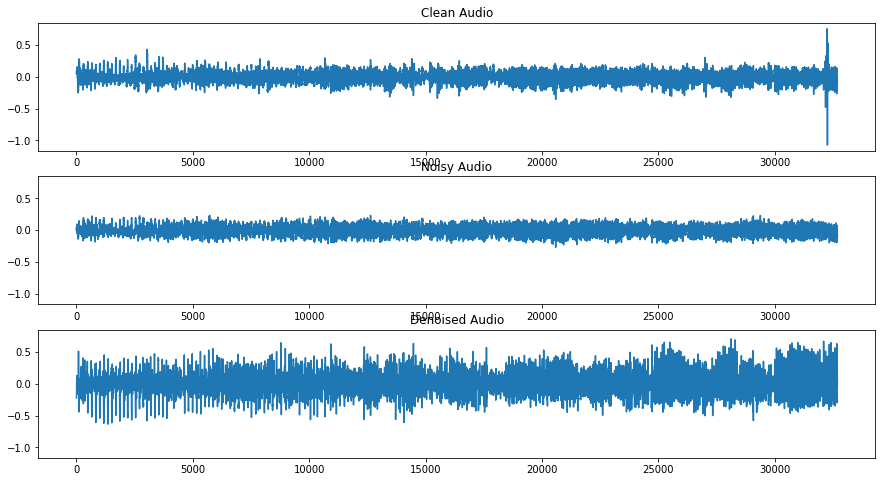

In [302]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15,8))

#plt.plot(figsize=(15,8))

ax1.plot(clean_audio)
ax1.set_title("Clean Audio")

ax2.plot(first_tt)
ax2.set_title("Noisy Audio")

ax3.plot(first_ts)
ax3.set_title("Denoised Audio")

In [300]:
first_ts.shape, first_tt.shape

((32704,), (32704,))

### outer noise source; irrelevant, poor performance

In [260]:
# cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'common_voice_en_16526.mp3'), sample_rate=fs)
# print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
# ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'common_voice_en_16526.wav'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.28595057 Max: 0.33333334


In [261]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '7913-3-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.2916928 Max: 0.33333334


In [262]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 9.200497e-08 Max: 12.195526


In [263]:
#cleanAudioFeatureExtractor.get_stft_spectrogram().dtype

In [264]:
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
print(noiseAudio.shape)
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

(15958,)


In [266]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 874)


In [267]:
noise_stft_features.shape

(129, 874)

In [268]:
predictors = prepare_input_features(noise_stft_features)
print('predictors.shape:', predictors.shape)

(129, 881)
predictors.shape: (129, 8, 874)


In [270]:
#np.allclose(predictors[:, 7, :], noise_stft_features)

In [271]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (874, 129, 8, 1)


In [272]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(874, 129, 1, 1)


In [274]:
mean, std

(0.25146738, 0.7065072)

In [275]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -1.254189 Max: 1.0572449


In [276]:
# no std and mean scaling
# somewhat better, but still barely better than noised version

denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -1.8117036 Max: 1.5202245


#### ------------------Time axis crop-------------------------(draft, irrelevant)

In [177]:


noise_stft_features_ = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase_ = np.angle(noise_stft_features_)
print(noisyPhase_.shape)
noise_stft_features_ = np.abs(noise_stft_features_)

noise_stft_features_ = noise_stft_features_[:, :512]
noisyPhase_ = noisyPhase[:, :512]

mean_ = np.mean(noise_stft_features_)
std_ = np.std(noise_stft_features_)
noise_stft_features_ = (noise_stft_features_ - mean_) / std_

(129, 874)


In [178]:
noise_stft_features_.shape

(129, 512)

In [179]:
noisyPhase_.shape

(129, 512)

In [180]:
predictors_ = prepare_input_features(noise_stft_features_)
print('predictors.shape:', predictors_.shape)

predictors.shape: (129, 8, 512)


In [181]:
predictors_ = np.reshape(predictors_, (predictors_.shape[0], predictors_.shape[1], 1, predictors_.shape[2]))
predictors_ = np.transpose(predictors_, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors_.shape)

predictors.shape: (512, 129, 8, 1)


In [182]:
STFTFullyConvolutional_ = model.predict(predictors_)
print(STFTFullyConvolutional_.shape)

(512, 129, 1, 1)


In [183]:
denoisedAudioFullyConvolutional_ = revert_features_to_audio(STFTFullyConvolutional_, noisyPhase_, mean_, std_)
print("Min:", np.min(denoisedAudioFullyConvolutional_),"Max:",np.max(denoisedAudioFullyConvolutional_))
ipd.Audio(data=denoisedAudioFullyConvolutional_, rate=fs) # load a local WAV file

Min: -0.21264848 Max: 0.25978088


In [ ]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

Text(0.5, 1.0, 'Denoised Audio')

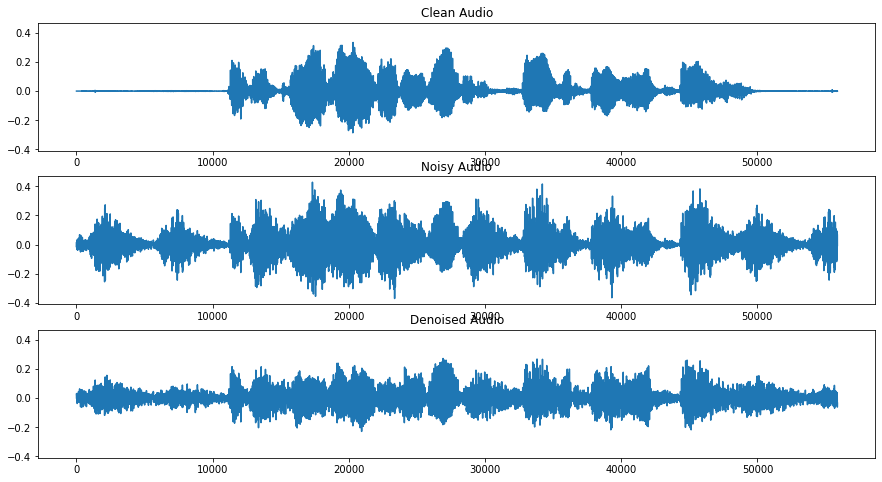

In [149]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15,8))

#plt.plot(figsize=(15,8))

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")